In [20]:
#-------------------------------- Cell 1 : Library and Environment Check.
import pandas
!pip install xgboost
!pip install seaborn
!pip install openpyxl


file_path = '/files/DSAP_Proj_FLFPGrowth/data/raw/children-per-woman-un.csv'
Adult_lit_fem_ds = pandas.read_csv(file_path)
print("File loaded successfully!")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
File loaded successfully!


In [21]:
import pandas as pd
import os
#-------------------------------- Cell 2: Load, Clean, and Filter Data (1991-2021)

base_dir = '/files/DSAP_Proj_FLFPGrowth/data/raw' 

files = {
    "Average Age of Mothers": 'average-age-of-mothers.csv',
    "Children per Woman": 'children-per-woman-un.csv',
    "Female Emp/Pop Ratio": 'modeled-female-employment-to-population-ratio.csv',
    "FLFP Rates": 'female-labor-force-participation-rates.csv',
    "GDP per Capita": 'gdp-per-capita-worldbank.csv',
    "Urban Population": 'urban-and-rural-population.csv',
    "Female Unemployment": 'unemployment-rate-women.csv',
    "Years of Schooling": 'years-of-schooling.csv',
    "WBL Index": 'WBLHistorical.xlsx'
}

def load_and_clean(path, name):
    try:
        # 1. Load the file
        if path.endswith('.xlsx') or path.endswith('.xls'):
            # SPECIAL CASE: Target the specific sheet for WBL
            if "WBL" in name:
                df = pd.read_excel(path, sheet_name="WBL Panel 2024")
            else:
                df = pd.read_excel(path)
        else:
            df = pd.read_csv(path)
        
        # 2. IMMEDIATE CLEANUP of Column Names
        df.columns = df.columns.astype(str).str.strip()
        
        # 3. SPECIAL HANDLING: WBL Index Renaming
        if "WBL" in name:
            if 'Report Year' in df.columns:
                df = df.rename(columns={'Report Year': 'Year'})
            if 'ISO Code' in df.columns:
                df = df.rename(columns={'ISO Code': 'Code'})
            elif 'Economy Code' in df.columns:
                df = df.rename(columns={'Economy Code': 'Code'})
            # The WBL index column itself is usually named 'WBL INDEX'
            if 'WBL INDEX' in df.columns:
                df = df.rename(columns={'WBL INDEX': 'WBL_Score'})

        # --- SPECIAL HANDLING: Average Age of Mothers ---
        if name == "Average Age of Mothers":
            df.columns = df.columns.str.replace('period-', '', regex=False)
            
        # --- SPECIAL HANDLING: Children per Woman ---
        if name == "Children per Woman":
            long_col = "Fertility rate - Sex: all - Age: all - Variant: estimates"
            if long_col in df.columns:
                df = df.rename(columns={long_col: "Children per Woman"})
            if 'time' in df.columns:
                df['Year'] = df['time']

        # 4. Standardize Country Name
        if 'Entity' not in df.columns:
            if 'Country Name' in df.columns: df = df.rename(columns={'Country Name': 'Entity'})
            elif 'Country' in df.columns: df = df.rename(columns={'Country': 'Entity'})
            elif 'Economy' in df.columns: df = df.rename(columns={'Economy': 'Entity'})

        # 5. Final Check and Year Formatting
        if 'Year' in df.columns:
            df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
            df = df.dropna(subset=['Year'])
            df['Year'] = df['Year'].astype(int)
            
            # Filter 1991-2021
            df_filtered = df[(df['Year'] >= 1991) & (df['Year'] <= 2021)].copy()
            return df_filtered
        
        else:
            print(f"Error: Still could not find 'Year' in {name}.")
            print(f"Available columns in sheet: {df.columns.tolist()[:10]}...") # Print first 10 for debug
            return pd.DataFrame()

    except Exception as e:
        print(f"Failed to load {name}: {e}")
        return pd.DataFrame()

# Load all files
data_frames = {}
print("--- Loading Files ---")
for name, filename in files.items():
    full_path = os.path.join(base_dir, filename)
    data_frames[name] = load_and_clean(full_path, name)

# Extract to variables
av_age_mothers_df = data_frames["Average Age of Mothers"]
child_per_wom_df = data_frames["Children per Woman"]
f_emp_pop_ratio_df = data_frames["Female Emp/Pop Ratio"]
FLFP_rates_df = data_frames["FLFP Rates"]
gdp_per_capita_df = data_frames["GDP per Capita"]
LT_urban_pop_df = data_frames["Urban Population"]
Unemp_rate_f_df = data_frames["Female Unemployment"]
years_school_df = data_frames["Years of Schooling"]
wbl_df = data_frames["WBL Index"]

# Final Verification
print("\n--- Final Row Counts (1991-2021) ---")
for name, df in data_frames.items():
    print(f"{name}: {len(df):,} rows")

--- Loading Files ---

--- Final Row Counts (1991-2021) ---
Average Age of Mothers: 7,843 rows
Children per Woman: 7,843 rows
Female Emp/Pop Ratio: 6,200 rows
FLFP Rates: 6,200 rows
GDP per Capita: 6,419 rows
Urban Population: 7,068 rows
Female Unemployment: 6,200 rows
Years of Schooling: 6,074 rows
WBL Index: 5,890 rows


In [22]:
#-------------------------------- Cell 3: Complete Cleaner & Merge ---

import pandas as pd
import gc

# 1. List of ALL 9 DataFrames
dfs_to_merge = [
    av_age_mothers_df, 
    child_per_wom_df, 
    f_emp_pop_ratio_df, 
    FLFP_rates_df, 
    gdp_per_capita_df, 
    LT_urban_pop_df, 
    Unemp_rate_f_df,
    years_school_df, 
    wbl_df # <--- Added here
]

# 2. Define the Cleaning Function
def clean_and_prep(df, index):
    # Work on a copy
    df = df.copy()
    
    # A. Standardize Column Names
    df.columns = df.columns.str.strip()
    
    if 'Country Code' in df.columns: df = df.rename(columns={'Country Code': 'Code'})
    if 'Country Name' in df.columns: df = df.rename(columns={'Country Name': 'Entity'})
    elif 'Country' in df.columns: df = df.rename(columns={'Country': 'Entity'})
        
    # B. Clean the Keys (Code and Year)
    if 'Code' not in df.columns or 'Year' not in df.columns:
        print(f"Warning: DF #{index} missing 'Code' or 'Year'. Skipping.")
        return None, None
    
    # Drop rows with missing keys
    df = df.dropna(subset=['Code', 'Year'])

    # 1. Clean CODE: Force to string
    df['Code'] = df['Code'].astype(str).str.strip()
    
    # 2. Clean YEAR: Force to integer
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df = df.dropna(subset=['Year'])
    df['Year'] = df['Year'].astype(int)

    # C. Remove Duplicates (1 row per Country-Year)
    df = df.drop_duplicates(subset=['Code', 'Year'])

    # D. Separate Data from Country Name
    code_map = {}
    if 'Entity' in df.columns:
        code_map = df[['Code', 'Entity']].drop_duplicates().set_index('Code')['Entity'].to_dict()
        df = df.drop(columns=['Entity']) 
        
    return df, code_map

# 3. Initialize the Master DataFrame
print("--- Starting Full Merge of 9 Files ---")

# Prep the first file
df_master, master_code_map = clean_and_prep(dfs_to_merge[0], 0)
print(f"Initialized with {len(df_master)} rows.")

# 4. Loop and Merge the Rest
for i in range(1, len(dfs_to_merge)):
    # Prep current file
    current_df, current_map = clean_and_prep(dfs_to_merge[i], i)
    
    if current_df is not None:
        # Update name list
        master_code_map.update(current_map)
        
        # Merge (Outer Join)
        try:
            df_master = pd.merge(df_master, current_df, on=['Code', 'Year'], how='outer')
        except Exception as e:
            print(f"Merge failed at file #{i}: {e}")
        
        # Memory Cleanup
        del current_df
        gc.collect()

# 5. Finish Up
# Re-attach Country Names
df_master['Country'] = df_master['Code'].map(master_code_map)

# Organize Columns
cols = ['Country', 'Code', 'Year'] + [c for c in df_master.columns if c not in ['Country', 'Code', 'Year']]
df_master = df_master[cols]
df_master = df_master.sort_values(by=['Country', 'Year']).reset_index(drop=True)

print("\nMerge Complete!")
print(f"Final Shape: {df_master.shape}")

# 6. Verify GDP Column
gdp_cols = [c for c in df_master.columns if "GDP" in c]
if gdp_cols:
    count = df_master[gdp_cols[0]].count()
    print(f"GDP Data Points: {count} (Target: ~6000)")
else:
    print(" GDP Column still missing!")

--- Starting Full Merge of 9 Files ---
Initialized with 7378 rows.

Merge Complete!
Final Shape: (7440, 65)
GDP Data Points: 6047 (Target: ~6000)


In [23]:
#-------------------------------- Cell 4: Rename and Organize Columns ---

import pandas as pd

# 1. Name of Step: Define Mapping
rename_map = {
    "WBL_Score": "WBL_Legal_Score",
    "age at childbearing": "Mean_Age_Mothers",
    "Fertility": "Fertility_Rate",         
    "Employment to population": "Fem_Emp_Pop_Ratio",
    "Labor force participation": "FLFP_Rate",
    "GDP per capita": "GDP_Per_Capita",
    "Urban population": "Urban_Pop_Rate",
    "Unemployment, female": "Fem_Unemp_Rate",
    "years of schooling": "Years_Schooling"
}

# 2. Name of Step: Apply Renaming
new_columns = []
for col in df_master.columns:
    renamed = False
    for keyword, short_name in rename_map.items():
        if keyword.lower() in str(col).lower():
            new_columns.append(short_name)
            renamed = True
            break
    if not renamed:
        new_columns.append(col)

df_master.columns = new_columns

# 3. Name of Step: Define Column Order
desired_order = [
    'Country', 'Code', 'Year', 
    'FLFP_Rate', 
    'WBL_Legal_Score', 
    'Fem_Emp_Pop_Ratio', 
    'Fem_Unemp_Rate', 
    'Mean_Age_Mothers', 
    'GDP_Per_Capita', 
    'Urban_Pop_Rate', 
    'Years_Schooling',
    'Fertility_Rate' 
]

# 4. Name of Step: Reorder and Filter
existing_cols = [c for c in desired_order if c in df_master.columns]
df_master = df_master[existing_cols]

# 5. Name of Step: Final Preview
print(f"Final Columns: {df_master.columns.tolist()}")
print(df_master.head())

Final Columns: ['Country', 'Code', 'Year', 'FLFP_Rate', 'WBL_Legal_Score', 'Fem_Emp_Pop_Ratio', 'Fem_Unemp_Rate', 'Mean_Age_Mothers', 'GDP_Per_Capita', 'Urban_Pop_Rate', 'Years_Schooling', 'Fertility_Rate']
       Country Code  Year  FLFP_Rate  WBL_Legal_Score  Fem_Emp_Pop_Ratio  \
0  Afghanistan  AFG  1991     15.740           25.625             14.075   
1  Afghanistan  AFG  1992     15.660           25.625             14.013   
2  Afghanistan  AFG  1993     15.544           25.625             13.930   
3  Afghanistan  AFG  1994     15.393           25.625             13.806   
4  Afghanistan  AFG  1995     15.226           25.625             13.656   

   Fem_Unemp_Rate  Mean_Age_Mothers  GDP_Per_Capita  Urban_Pop_Rate  \
0          10.580            29.677             NaN       2602720.0   
1          10.515            29.697             NaN       2835725.0   
2          10.379            29.716             NaN       3204414.0   
3          10.310            29.599             NaN 

In [24]:
#-------------------------------- Cell 5: Filter Non-Countries, Remove Empty Rows, and Save ---

import pandas as pd

# 1. Define Non-Country Entities to Remove
entities_to_drop = [
    "World",
    "Arab World", "European Union", "OECD members",
    "High income", "Upper middle income", "Middle income", 
    "Lower middle income", "Low income", "Sub-Saharan Africa",
    "East Asia & Pacific", "Europe & Central Asia", 
    "Latin America & Caribbean", "Middle East & North Africa",
    "North America", "South Asia"
]

# 2. Define Missing Data Threshold
MISSING_THRESHOLD = 0.25 

# --- EXECUTE FILTERING ---

print(f"Original Country Count: {df_master['Country'].nunique()}")

# A. Remove known non-country entities
df_clean = df_master[~df_master['Country'].isin(entities_to_drop)].copy()

# B. Remove "High Missingness" Countries
data_cols = [c for c in df_clean.columns if c != 'Country']

# Calculate % missing for each country (Sum of NaNs / Total Cells)
missing_series = df_clean[data_cols].groupby(df_clean['Country']).apply(lambda x: x.isnull().sum().sum() / x.size)

bad_countries = missing_series[missing_series > MISSING_THRESHOLD].index.tolist()

# Drop them
df_clean = df_clean[~df_clean['Country'].isin(bad_countries)]

# C. Drop the useless "OWID" column if it exists
if "World regions according to OWID" in df_clean.columns:
    df_clean = df_clean.drop(columns=["World regions according to OWID"])

# --- SAVE AND SUMMARY ---

# Save to CSV
output_filename = 'master_dataset_clean.csv'
df_clean.to_csv(output_filename, index=False)

print(f"\nFiltering Complete!")
print(f"Removed Manual List: {len(df_master['Country'].unique()) - len(df_master[~df_master['Country'].isin(entities_to_drop)]['Country'].unique())} entities")
print(f"Removed High-Missingness Countries: {len(bad_countries)}")
print(f"   -> Dropped: {bad_countries}")
print(f"Final Country Count: {df_clean['Country'].nunique()}")
print(f"Saved to: {output_filename}")

# Final Stats
print("\n--- Final Data Completeness ---")
print(df_clean.count())

Original Country Count: 239

Filtering Complete!
Removed Manual List: 1 entities
Removed High-Missingness Countries: 56
   -> Dropped: ['American Samoa', 'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Bermuda', 'Bonaire Sint Eustatius and Saba', 'British Virgin Islands', 'Cayman Islands', 'Channel Islands', 'Cook Islands', 'Curacao', 'Dominica', 'Falkland Islands', 'Faroe Islands', 'French Guiana', 'French Polynesia', 'Gibraltar', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guernsey', 'Isle of Man', 'Jersey', 'Kiribati', 'Kosovo', 'Liechtenstein', 'Marshall Islands', 'Martinique', 'Mayotte', 'Micronesia, Fed. Sts.', 'Monaco', 'Montserrat', 'Nauru', 'New Caledonia', 'Niue', 'North Korea', 'Northern Mariana Islands', 'Palau', 'Reunion', 'Saint Barthelemy', 'Saint Helena', 'Saint Martin (French part)', 'Saint Pierre and Miquelon', 'San Marino', 'Seychelles', 'Sint Maarten (Dutch part)', 'St. Kitts and Nevis', 'Taiwan, China', 'Tokelau', 'Turks and Caicos Islands', 'Tuvalu', 'V

In [34]:
#-------------------------------- Cell 6: Feature Engineering (Lagged) ---

import pandas as pd
import numpy as np

# 1. Name of Step: Filter 5-Year Intervals
years_of_interest = [1991, 1996, 2001, 2006, 2011, 2016, 2021]
df_panel = df_clean[df_clean['Year'].isin(years_of_interest)].copy()
df_panel = df_panel.sort_values(by=['Code', 'Year'])

# 2. Name of Step: Calculate 5-Year Lag for WBL
# This uses the legal score from the PREVIOUS 5-year period
df_panel['WBL_Lagged'] = df_panel.groupby('Code')['WBL_Legal_Score'].shift(1)

# 3. Name of Step: Calculate Target (Growth)
df_panel['Next_FLFP'] = df_panel.groupby('Code')['FLFP_Rate'].shift(-1)
df_panel['FLFP_Growth_Next_5Y'] = (df_panel['Next_FLFP'] - df_panel['FLFP_Rate']) / df_panel['FLFP_Rate']

# 4. Name of Step: Cleanup
df_model = df_panel.dropna(subset=['FLFP_Growth_Next_5Y', 'WBL_Lagged']).copy()

# 5. Name of Step: Define Features (Using Lagged WBL)
X_cols = [
    'Fem_Emp_Pop_Ratio', 
    'Fem_Unemp_Rate', 
    'Mean_Age_Mothers', 
    'GDP_Per_Capita', 
    'Urban_Pop_Rate', 
    'Years_Schooling', 
    'Fertility_Rate',
    'WBL_Lagged' # <--- Predicting future growth using past laws
]
y_col = 'FLFP_Growth_Next_5Y'

# 6. Name of Step: Temporal Split
train_years = [1996, 2001, 2006] # Starts at 1996 because 1991 is now a lag
test_years = [2011, 2016]

X_train = df_model.loc[df_model['Year'].isin(train_years), X_cols]
y_train = df_model.loc[df_model['Year'].isin(train_years), y_col]
X_test = df_model.loc[df_model['Year'].isin(test_years), X_cols]
y_test = df_model.loc[df_model['Year'].isin(test_years), y_col]

print(f"Ready with {len(X_train)} training and {len(X_test)} test samples.")

Ready with 534 training and 356 test samples.


In [35]:
#-------------------------------- Cell 7: Model Training and Evaluation ---

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 1. Setup Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0), # L2 Regularization
    "Lasso Regression": Lasso(alpha=0.01), # L1 Regularization (Good for feature selection)
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# 2. Define Validation Strategy
# 5-Fold CV: Splits the training data into 5 parts to ensure the model isn't just memorizing
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

print("--- Model Performance ---")
print(f"{'Model':<20} | {'CV R2 (Train)':<15} | {'Test RMSE':<12} | {'Test R2':<10}")
print("-" * 65)

# 3. Training Loop
for name, model in models.items():
    
    # Create Pipeline: 
    # 1. Imputer: Fills any tiny gaps 
    # 2. Scaler: Standardizes data 
    # 3. Model: The regressor
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), 
        ('scaler', StandardScaler()), 
        ('model', model)
    ])
    
    # A. Cross-Validation on Training Set (1991-2006)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2')
    mean_cv_r2 = cv_scores.mean()
    
    # B. Train on Full Training Set
    pipeline.fit(X_train, y_train)
    
    # C. Predict on Test Set (2011-2016)
    y_pred = pipeline.predict(X_test)
    
    # D. Calculate Metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.append({
        "Model": name,
        "CV_R2": mean_cv_r2,
        "Test_RMSE": test_rmse,
        "Test_R2": test_r2,
        "Pipeline": pipeline # Save the trained model for later (SHAP)
    })
    
    print(f"{name:<20} | {mean_cv_r2:.4f}          | {test_rmse:.4f}       | {test_r2:.4f}")

# 4. Save best model for interpretation (sort by Test R2 to find the winner)
results_df = pd.DataFrame(results).sort_values(by='Test_R2', ascending=False)
best_model_name = results_df.iloc[0]['Model']
best_pipeline = results_df.iloc[0]['Pipeline']

print(f"\nBest Model: {best_model_name}")

--- Model Performance ---
Model                | CV R2 (Train)   | Test RMSE    | Test R2   
-----------------------------------------------------------------
Linear Regression    | 0.1019          | 0.0802       | 0.0166
Ridge Regression     | 0.1021          | 0.0802       | 0.0168
Lasso Regression     | 0.0602          | 0.0813       | -0.0090
Random Forest        | 0.1046          | 0.0811       | -0.0055
XGBoost              | 0.0409          | 0.0835       | -0.0654

Best Model: Ridge Regression


/tmp/ipykernel_65/4048724857.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')


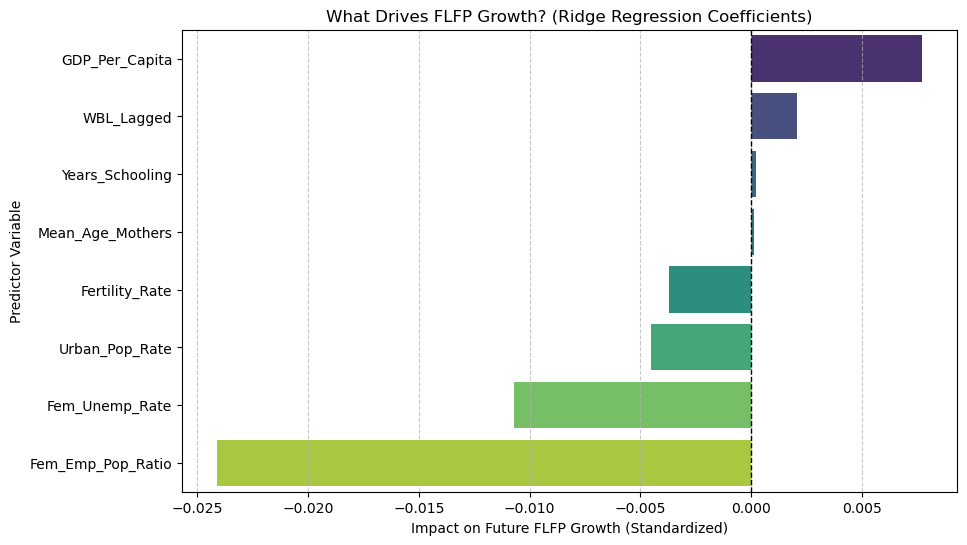

--- Feature Impacts (Standardized) ---
             Feature  Coefficient
3     GDP_Per_Capita     0.007707
7         WBL_Lagged     0.002053
5    Years_Schooling     0.000228
2   Mean_Age_Mothers     0.000119
6     Fertility_Rate    -0.003699
4     Urban_Pop_Rate    -0.004506
1     Fem_Unemp_Rate    -0.010685
0  Fem_Emp_Pop_Ratio    -0.024108


In [36]:
#-------------------------------- Cell 8: Visualize Ridge Coefficients ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract the model and feature names
ridge_model = best_pipeline.named_steps['model']
feature_names = X_cols

# 2. Get the Coefficients
coefficients = ridge_model.coef_

# 3. Create a DataFrame for Plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# 4. Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')

# Add a vertical line at 0 for clarity
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.title('What Drives FLFP Growth? (Ridge Regression Coefficients)')
plt.xlabel('Impact on Future FLFP Growth (Standardized)')
plt.ylabel('Predictor Variable')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 5. Print the exact numbers
print("--- Feature Impacts (Standardized) ---")
print(coef_df)

/tmp/ipykernel_65/1303554294.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


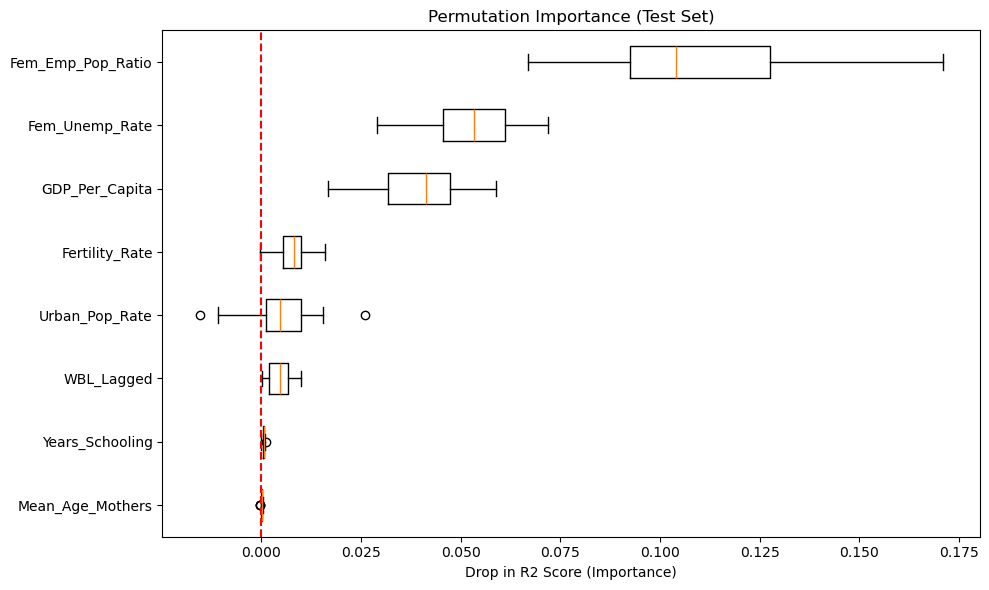

--- Feature Importance (Ranked) ---
             Feature  Importance_Mean  Importance_Std
0  Fem_Emp_Pop_Ratio         0.109152        0.022642
1     Fem_Unemp_Rate         0.053479        0.010442
3     GDP_Per_Capita         0.040396        0.010987
6     Fertility_Rate         0.007681        0.003764
4     Urban_Pop_Rate         0.005143        0.007928
7         WBL_Lagged         0.004408        0.002736
5    Years_Schooling         0.000469        0.000304
2   Mean_Age_Mothers        -0.000013        0.000138


In [37]:
#-------------------------------- Cell 9: Permutation Importance (Verification) ---

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# 1. Calculate Permutation Importance
perm_importance = permutation_importance(
    best_pipeline, X_test, y_test, 
    n_repeats=30, random_state=42, scoring='r2'
)

# 2. Organize Data
sorted_idx = perm_importance.importances_mean.argsort()
features = np.array(X_cols)

# 3. Plot
plt.figure(figsize=(10, 6))
plt.boxplot(
    perm_importance.importances[sorted_idx].T,
    vert=False,
    labels=features[sorted_idx]
)
plt.title("Permutation Importance (Test Set)")
plt.xlabel("Drop in R2 Score (Importance)")
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# 4. Print Summary
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

print("--- Feature Importance (Ranked) ---")
print(importance_df)

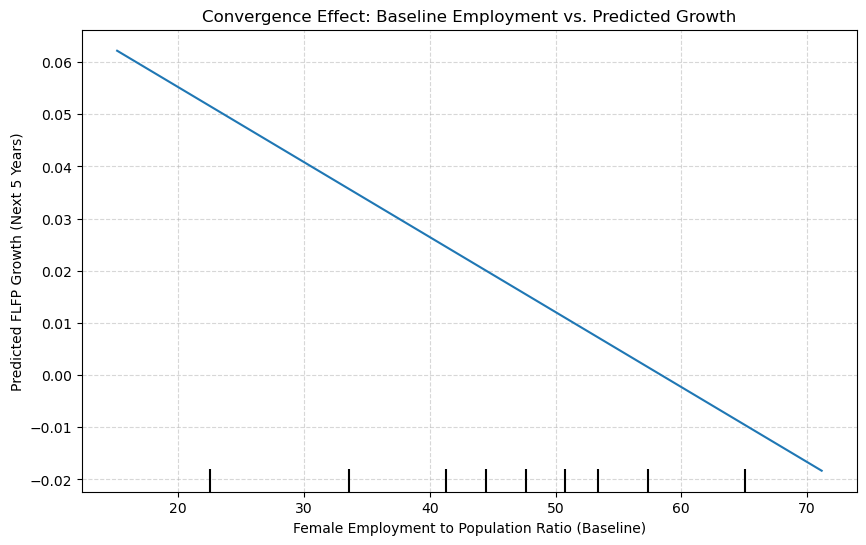

In [38]:
#-------------------------------- Cell 10: Partial Dependence Plot (The Convergence Effect) ---

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# 1. Setup the plot
fig, ax = plt.subplots(figsize=(10, 6))

# 2. Calculate Partial Dependence
PartialDependenceDisplay.from_estimator(
    best_pipeline, 
    X_test, 
    features=['Fem_Emp_Pop_Ratio'], 
    kind='average',
    ax=ax
)

plt.title(f"Convergence Effect: Baseline Employment vs. Predicted Growth")
plt.xlabel("Female Employment to Population Ratio (Baseline)")
plt.ylabel("Predicted FLFP Growth (Next 5 Years)")
plt.grid(linestyle='--', alpha=0.5)
plt.show()

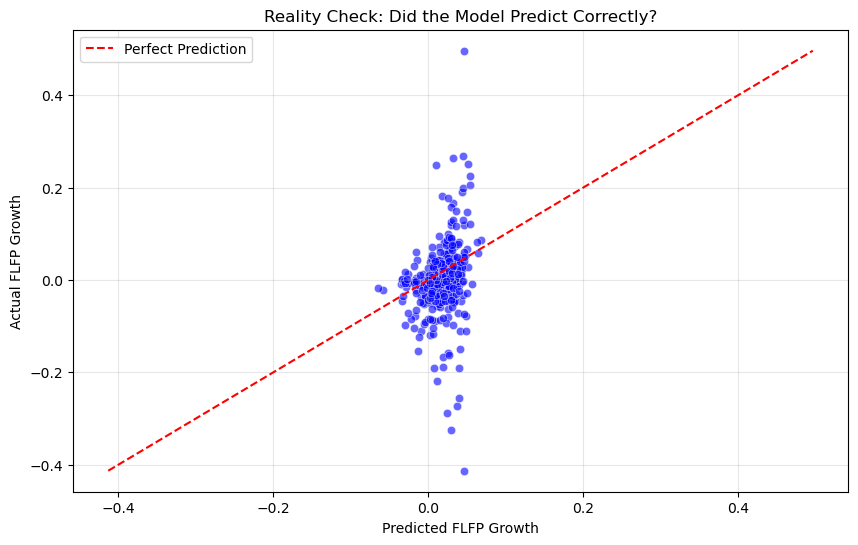

--- Top 5 'Miracle' Countries (Overperformers) ---
           Country  Year  Actual_Growth  Predicted_Growth  Residual
5698  Saudi Arabia  2016       0.496501          0.045795  0.450706
769        Bolivia  2016       0.248406          0.010063  0.238342
521     Bangladesh  2016       0.263994          0.031654  0.232340
20     Afghanistan  2011       0.268072          0.044357  0.223715
4081         Malta  2011       0.251549          0.051308  0.200241


In [39]:
#-------------------------------- Cell 11: Predicted vs. Actual Growth (The "Reality Check") ---

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Predict on the Test Set again
y_pred = best_pipeline.predict(X_test)

# 2. Create a Comparison DataFrame
results_df = X_test.copy()
results_df['Actual_Growth'] = y_test
results_df['Predicted_Growth'] = y_pred
results_df['Residual'] = results_df['Actual_Growth'] - results_df['Predicted_Growth']

# Add Country and Year back for context (we align by index)
results_df['Country'] = df_model.loc[X_test.index, 'Country']
results_df['Year'] = df_model.loc[X_test.index, 'Year']

# 3. Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='Predicted_Growth', y='Actual_Growth', alpha=0.6, color='blue')

# Add the perfect prediction line
min_val = min(results_df['Actual_Growth'].min(), results_df['Predicted_Growth'].min())
max_val = max(results_df['Actual_Growth'].max(), results_df['Predicted_Growth'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

plt.title('Reality Check: Did the Model Predict Correctly?')
plt.xlabel('Predicted FLFP Growth')
plt.ylabel('Actual FLFP Growth')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Highlight the "Miracle" Countries (Top Overperformers)
overperformers = results_df.sort_values(by='Residual', ascending=False).head(5)

print("--- Top 5 'Miracle' Countries (Overperformers) ---")
print(overperformers[['Country', 'Year', 'Actual_Growth', 'Predicted_Growth', 'Residual']])

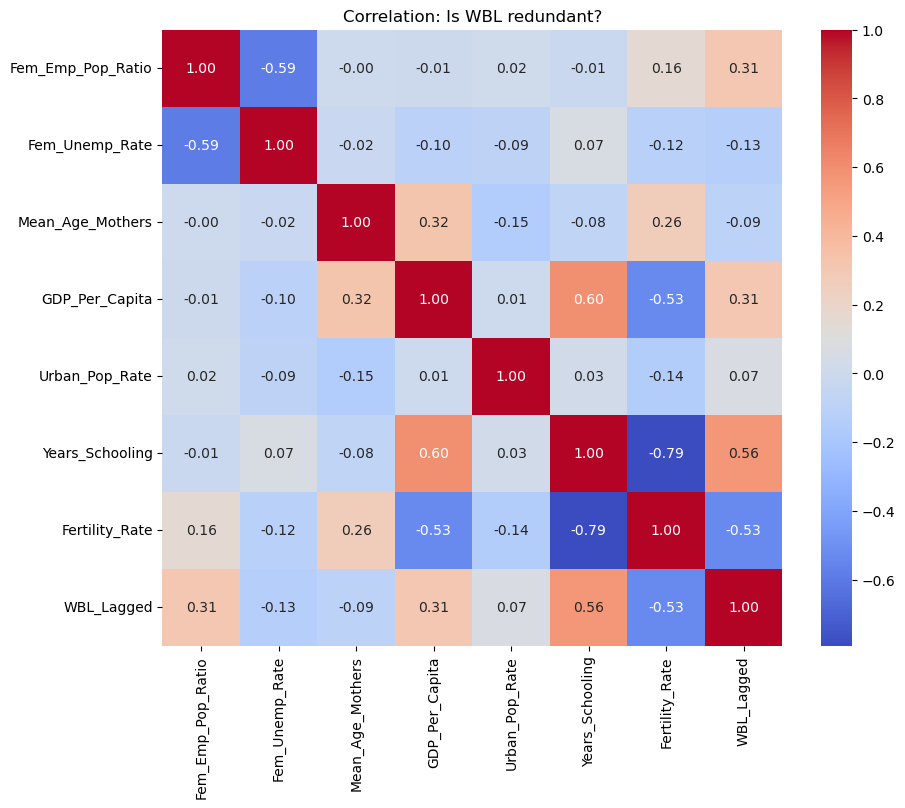

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check how WBL relates to other predictors
plt.figure(figsize=(10, 8))
correlation_matrix = df_model[X_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation: Is WBL redundant?")
plt.show()